In [1]:
from imageio import imread, imsave
import numpy as np
import cv2
import meshplot
from imageio import imread, imsave
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import cv2
import meshplot as mp

# Problem 1

I referenced the following links:
- https://cseweb.ucsd.edu/classes/sp19/cse152-a/hw2/HW2.pdf
- https://stackoverflow.com/questions/46607647/sift-feature-matching-point-coordinates

In [42]:
def sampson_distance(F, x1, x2):
 
    # Compute sampson error for each correspondence.
    Fx1 = np.dot(F, x1)
    Fx2 = np.dot(F, x2)
    denom = Fx1[0]**2 + Fx1[1]**2 + Fx2[0]**2 + Fx2[1]**2
    err = ( np.diag(np.dot(x1.T, np.dot(F,x2))) )**2 / denom 

    # return error per point
    return err

def compute_epipole(F):
    """ Computes the (right) epipole from a
    fundamental matrix F.
    (Use with F.T for left epipole.) """
    
    # Fe_1 = 0, thus need to return null space of F (Fx = 0)
    pass

def plot_epipolar_line(im, F, x, epipole=None, show_epipole=True, start=0):
    """ Plot the epipole and epipolar line F*x=0
        in an image. F is the fundamental matrix 
        and x a point in the other image."""
    
    m,n = im.shape[:2]
    line = np.dot(F,x)
    
    # epipolar line parameter and values
    t = np.linspace(start,n,100)
    lt = np.array([(line[2]+line[0]*tt)/(-line[1]) for tt in t])

    # take only line points inside the image
    ndx = (lt>=0) & (lt<m) 
    plt.plot(t[ndx],lt[ndx],linewidth=2)
    
    if show_epipole:
        if epipole is None:
            epipole = compute_epipole(F)
        plt.plot(epipole[0]/epipole[2],epipole[1]/epipole[2],'r*')

def compute_fundamental(x1,x2):
    """ Computes the fundamental matrix from corresponding points
    (x1,x2 3xn arrays) using the 8 point algorithm.
    each row is constructed as
    [x’*x, x’*y, x’, y’*x, y’*y, y’, x, y, 1] """
    
    n = x1.shape[1]
    A = np.zeros((n, 9))
    for i in range(n):
        A[i] = [
            x1[0, i] * x2[0, i], x1[0, i] * x2[1, i], x1[0, i] * x2[2, i],
            x1[1, i] * x2[0, i], x1[1, i] * x2[1, i], x1[1, i] * x2[2, i],
            x1[2, i] * x2[0, i], x1[2, i] * x2[1, i], x1[2, i] * x2[2, i]
        ]
    U, S, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)
    U, S, V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U, np.dot(np.diag(S), V))
    return F / F[2, 2]

def compute_fundamental_normalized(x1,x2):
    """    Computes the fundamental matrix from corresponding points 
        (x1,x2 3xn arrays) using the normalized 8 point algorithm. """

    # normalize image coordinates
    x1n = x1 / x1[2]
    mean1 = np.mean(x1[:2], axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([
        [S1, 0, -S1 * mean1[0]],
        [0, S1, -S1 * mean1[1]],
        [0, 0, 1]
    ])
    x1n = np.dot(T1, x1n)
    
    x2n = x2 / x1[2]
    mean2 = np.mean(x2[:2], axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([
        [S2, 0, -S2 * mean2[0]],
        [0, S2, -S2 * mean2[1]],
        [0, 0, 1]
    ])
    x2n = np.dot(T2, x2n)

    # compute F with the normalized coordinates
    F = compute_fundamental(x1n, x2n)

    return F

def skew(a):
    """ Skew matrix A such that a x v = Av for any v. """
    return np.array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])

def make_homog(points):
    return np.vstack((points, np.ones((1, points.shape[1]))))


def triangulate(x1, x2, P1, P2):
    """    
    Two-view triangulation of points in x1,x2 (3xn homog. coordinates). 
    Return: 3xn point cloud
    """
    pass

def extract_correspondences(im1, im2, coeff=0.5):
    # similar to your panorama implementation, can copy/paste
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(im1, None)
    kp2, desc2 = sift.detectAndCompute(im2, None)
    matches = cv2.BFMatcher().knnMatch(desc1, desc2, k=2)
    
    matches_for_plot = []
    pts1 = []
    pts2 = []
    for m1, m2 in matches:
        if m1.distance > coeff * m2.distance:
            continue
        matches_for_plot.append([m1])
        pt1 = kp1[m1.queryIdx].pt
        pt2 = kp2[m1.trainIdx].pt
        pts1.append(pt1)
        pts2.append(pt2)
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)

    return pts1, pts2, matches_for_plot, kp1, kp2

In [43]:
merton1 = imread("data/merton1.jpg")
merton2 = imread("data/merton2.jpg")

In [44]:
pts1, pts2, matches_for_plot, kp1, kp2 = extract_correspondences(
    cv2.cvtColor(merton1, cv2.COLOR_BGR2GRAY), 
    cv2.cvtColor(merton2, cv2.COLOR_BGR2GRAY), 
    coeff=0.3)

In [45]:
pts1.shape

(141, 2)

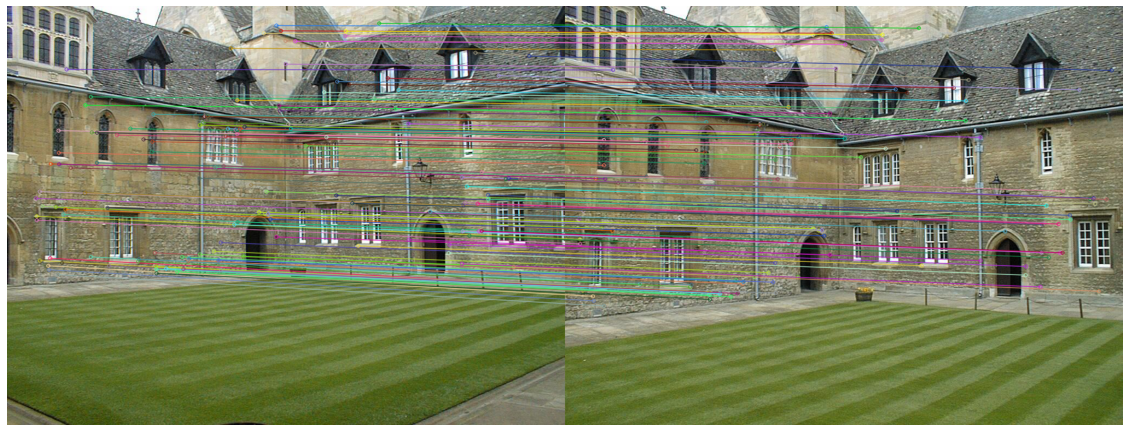

In [46]:
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(merton1, kp1, merton2,
                          kp2, matches_for_plot, None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(img3)
plt.show()

In [47]:
# Sampson error

x1 = pts1
x2 = pts2
x1 = make_homog(x1.T)
x2 = make_homog(x2.T)

F = compute_fundamental(x1, x2)

error = sampson_distance(F, make_homog(pts1.T), make_homog(pts2.T))
print(np.median(error))
print("Average Sampson error: {}".format(np.mean(error)))

10.2145213530057
Average Sampson error: 72.67780817488426


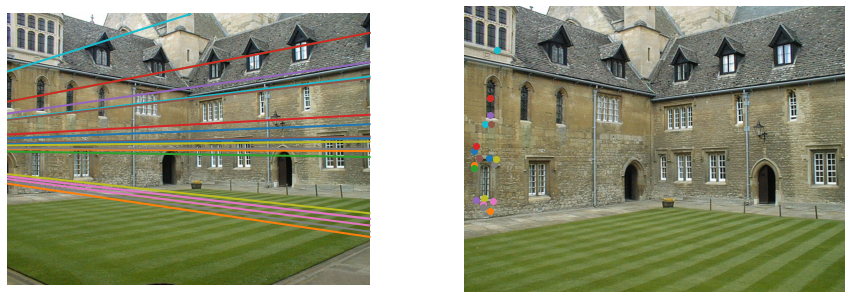

In [48]:
# Epiline plotting

rand_ind = np.random.permutation(pts2.shape[0])

e = compute_epipole(F)

plt.figure(1, figsize=(15,10))
plt.subplot(121)
plt.axis('off')
plt.imshow(merton1)

for i in range(20):
    x = make_homog(pts1.T).T[rand_ind[i],:]
    plot_epipolar_line(merton1, F, x2[:,i], e, False)

plt.subplot(122)
 
plt.axis('off')
plt.imshow(merton2)

for i in range(20):
    plt.plot(x2[0,i],x2[1,i],'o')
    

plt.show()

In [ ]:
# Epipole plotting

plt.figure(1, figsize=(30,20))

plt.subplot(122)
plt.axis('off')
plt.imshow(merton1)

plt.figure(1, figsize=(15,10))

e = compute_epipole(F.T)

for i in range(20):
    x = make_homog(pts1.T).T[rand_ind[i],:]
    plot_epipolar_line(merton1, F, x2[:,i], e, True, start=-1000)

    
plt.show()

In [ ]:
# Triangulation

P1 = np.loadtxt("data/001.P")
P2 = np.loadtxt("data/002.P")

pts1, pts2, match_for_plot, kp1, kp2 = extract_correspondences(merton1, merton2, coeff=0.8)

x1 = pts1
x2 = pts2

x1 = make_homog(x1.T)
x2 = make_homog(x2.T)

colors = []

for i in range(pts1.shape[0]):
    u, v = pts1[i,:]
    colors.append(merton1[v, u,:]/255.)
    
colors = np.array(colors)
points_est = triangulate(x1, x2, P1, P2)[:3,:].T

d = mp.subplot(v=points_est, c=colors, s=[1, 2, 0], shading={"point_size": 0.5})

# Problem 2

In [ ]:
import math
from skimage import io, color
import numpy as np
from tqdm import trange

# note: you can convert to LAB with lab_arr = color.rgb2lab(rgb)

if __name__ == '__main__':
    p = SLIC('data/elon.png', K=300, M=40)
    p.iterate()

